In [1]:
import os 
import cv2
import glob
import pandas as pd
import numpy as np
import seaborn as sn
import joblib    
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [2]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 224, 224, 3)
[0 1 1 1 0 2 0 1 1 1 2 0 2 1 1 2 1 2 2 1 0 2 1 2 0 0 0 2 1 2 0 2]


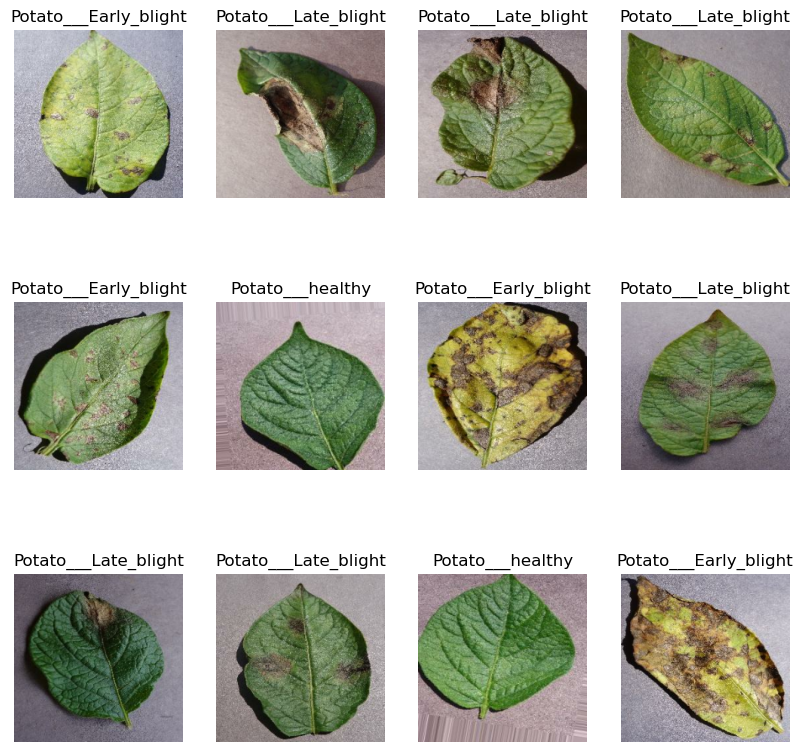

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [7]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
n_classes=3
model = Sequential()
model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
model.add(BatchNormalization())
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units = n_classes, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                      

In [11]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(    
    train_ds,
    steps_per_epoch=None,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=4,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

Epoch 1/30
37/37 [==============================] - 51s 1s/step - loss: 1.2553 - accuracy: 0.7373 - val_loss: 976.6821 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/30
37/37 [==============================] - 51s 1s/step - loss: 0.4517 - accuracy: 0.8559 - val_loss: 63.0155 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 3/30
37/37 [==============================] - 50s 1s/step - loss: 0.3477 - accuracy: 0.8771 - val_loss: 6.7244 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 4/30
37/37 [==============================] - 50s 1s/step - loss: 0.2816 - accuracy: 0.8958 - val_loss: 6.3198 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/30
37/37 [==============================] - 50s 1s/step - loss: 0.2672 - accuracy: 0.8941 - val_loss: 1.1465 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 6/30
37/37 [==============================] - 50s 1s/step - loss: 0.3164 - accuracy: 0.8839 - val_loss: 1.4311 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 7/30
37/37 [==============================] - 50s 1s/step - loss: 0.2086 

In [12]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 2s 210ms/step - loss: 0.0600 - accuracy: 0.9740


[0.06004173681139946, 0.9739583134651184]

In [13]:
history.history['loss']

[1.2553198337554932,
 0.4517209827899933,
 0.34774136543273926,
 0.28155940771102905,
 0.2672189474105835,
 0.3163548409938812,
 0.20859383046627045,
 0.21935318410396576,
 0.21489593386650085,
 0.20008063316345215,
 0.11006958782672882,
 0.06384313851594925,
 0.041276950389146805,
 0.026344336569309235,
 0.02043055184185505,
 0.01889708824455738,
 0.01456534955650568,
 0.01437150314450264,
 0.013561408966779709,
 0.012470554560422897,
 0.011570211499929428,
 0.01230244617909193,
 0.012782351113855839,
 0.010375403799116611,
 0.011039411649107933,
 0.00993811059743166,
 0.008810442872345448,
 0.007791940122842789,
 0.008499193005263805,
 0.0082467095926404]

In [14]:
history.history['accuracy']

[0.7372881174087524,
 0.8559321761131287,
 0.8771186470985413,
 0.8957627415657043,
 0.8940678238868713,
 0.8838983178138733,
 0.9262712001800537,
 0.9186440706253052,
 0.9237288236618042,
 0.9271186590194702,
 0.9584745764732361,
 0.9788135886192322,
 0.988135576248169,
 0.9906779527664185,
 0.9957627058029175,
 0.996610164642334,
 0.9991525411605835,
 0.998305082321167,
 0.9991525411605835,
 0.998305082321167,
 1.0,
 0.996610164642334,
 0.9974576234817505,
 0.9991525411605835,
 0.9991525411605835,
 0.9991525411605835,
 1.0,
 1.0,
 0.9991525411605835,
 1.0]

In [15]:
history.history['val_loss']

[976.68212890625,
 63.01554870605469,
 6.724371910095215,
 6.319788455963135,
 1.1464989185333252,
 1.4310673475265503,
 0.45864546298980713,
 0.6472930908203125,
 1.2385294437408447,
 9.41108226776123,
 1.5881346464157104,
 1.481063961982727,
 2.0303473472595215,
 1.4897756576538086,
 0.8904539942741394,
 0.5593101382255554,
 0.3294820487499237,
 0.20126353204250336,
 0.12334291636943817,
 0.08291836827993393,
 0.05596901848912239,
 0.05036787688732147,
 0.04492837190628052,
 0.04648730903863907,
 0.03938150405883789,
 0.037534963339567184,
 0.03624580800533295,
 0.03580047935247421,
 0.0393153615295887,
 0.04203089699149132]

In [16]:
history.history['val_accuracy']

[0.375,
 0.359375,
 0.453125,
 0.53125,
 0.671875,
 0.6875,
 0.859375,
 0.734375,
 0.6953125,
 0.375,
 0.546875,
 0.59375,
 0.578125,
 0.6484375,
 0.7421875,
 0.8203125,
 0.8515625,
 0.90625,
 0.953125,
 0.9765625,
 0.9921875,
 0.9921875,
 0.9921875,
 0.9921875,
 0.9921875,
 0.9921875,
 0.9921875,
 0.9921875,
 0.9921875,
 0.9921875]

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

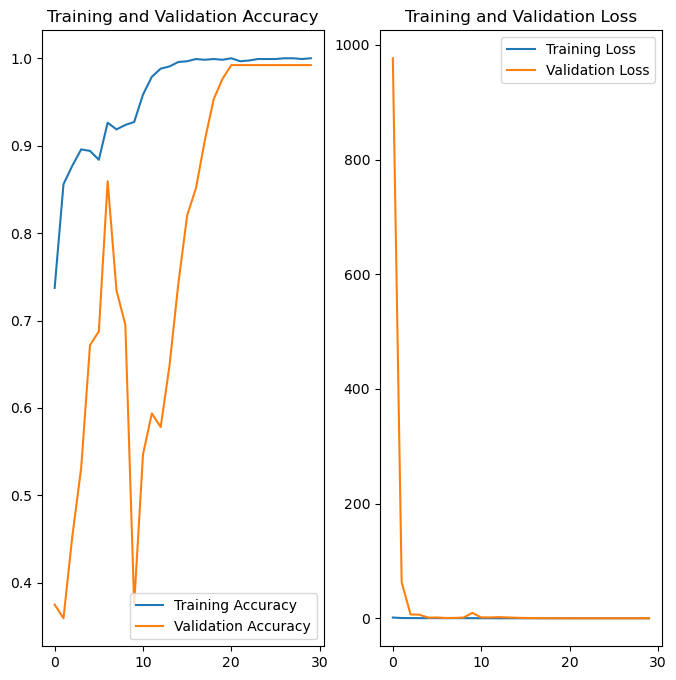

In [18]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
first image's actual label:  Potato___healthy
1/1 [==============================] - 0s 390ms/step
[2.5661237e-07 2.5551217e-03 9.9744463e-01]
predicted label:  Potato___healthy


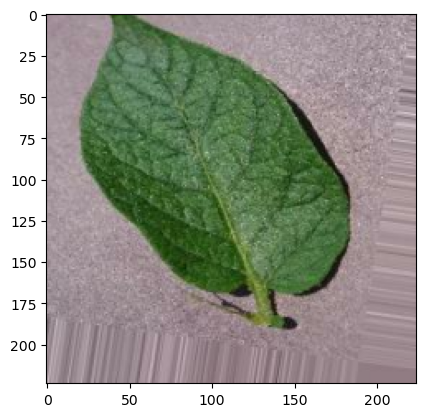

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=(images_batch[0].numpy().astype('uint8'))
    first_label=labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


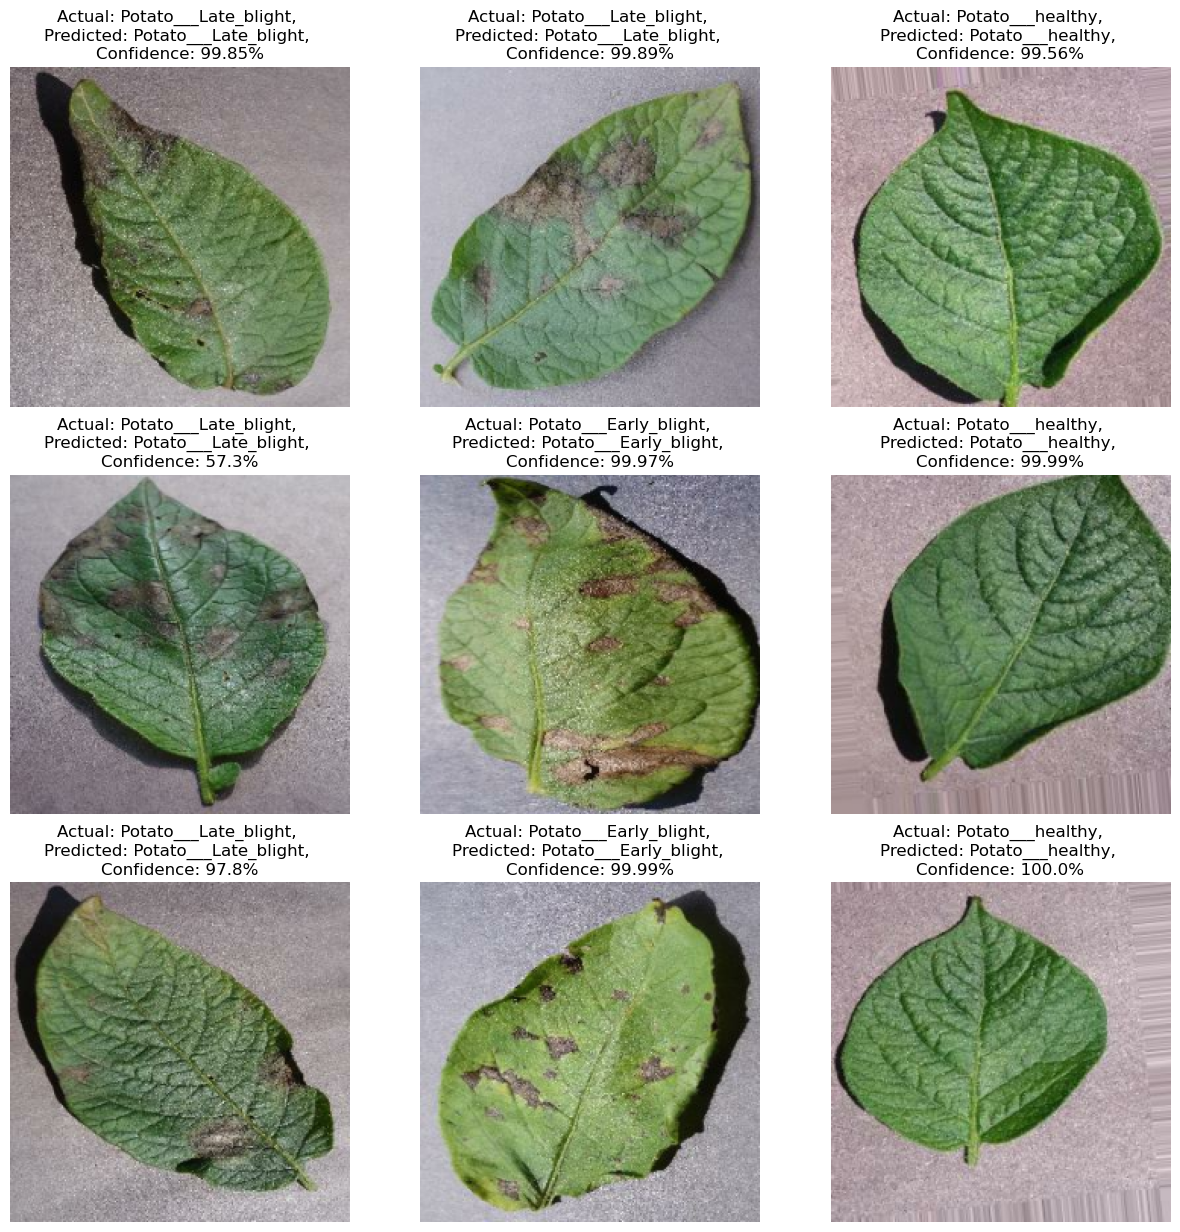

In [21]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 270ms/step


In [23]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.96      0.97      0.97        75
           2       0.98      0.98      0.98        63

    accuracy                           0.97       192
   macro avg       0.98      0.97      0.97       192
weighted avg       0.97      0.97      0.97       192



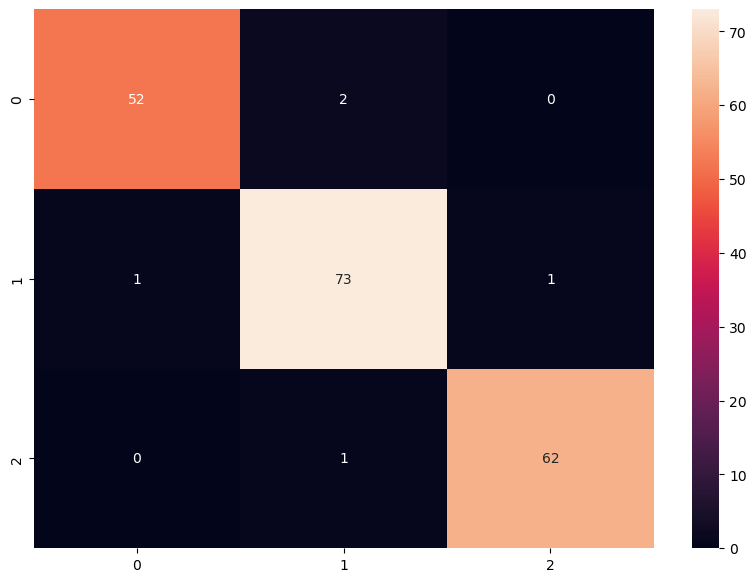

In [24]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [25]:
filename = "Model6-2-Epochs30.joblib"
joblib.dump(model, filename)

['Model6-2-Epochs30.joblib']